# A new business 

The business team has a new idea.

They want to buy cheap electricty, store it in a battery and sell it when it becomes more expensive.

* The buy and sell plan must be decided before the price is known
* We will systematically sell after a fix time what was purchased

(this prevents the stored electricity to grow continuously and simplifies the model)


They ask you: **can you predict the electricity price accurately** enough for the plan to work?

## Download the data
We will use a public electricity dataset

http://jepx.org/english/index.html

In [1]:
#! wget http://jepx.org/market/excel/spot_2019.csv

## Causal models

* Correlation is not causation
* You cannot in general find causes in data unless you have an external model

What are the causes of electricity price?



In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('data/spot_2019.csv', encoding='SHIFT_JIS', parse_dates=['年月日'])

In [4]:
df = df[df.columns[:15]]
df.columns = [
    'date', 'slot',
    'sell_bids', 'buy_bids', 'traded', 'system',
    'hokkaido', 'tohoku', 'tokyo',
    'chubu', 'hokuriku', 'kansai',
    'chugoku', 'shikoku', 'kyushu']

In [5]:
df['datetime'] = df.date + pd.to_timedelta((df.slot-1) * 30, 'Min')
df = df.set_index('datetime')
df['weekday'] = df.date.dt.weekday # for later

# Splitting the dataset

Im machine learning, it is important to not use all your dataset and keep part of it for validation and testing.

* a training set on which you et your modle learn
* a validation set that you use to choose between different solutions
* a test set that is used to estimate the performance to be expected once deployed

For many type of datasets, samples should be assigned randomly to each set, but for timeseries, sequence should be preserved.
NB: you normally don't look at test data at this stage, otherwise you will start to inject test data information in your model, and the performance estimate will be biased

In [6]:
len(df)/48

130.0

In [7]:
df_train = df[:48*90].copy()
df_test = df[48*90:48*110].copy()

## First observations

In [8]:
df_test.head()

,date,slot,sell_bids,buy_bids,traded,system,hokkaido,tohoku,tokyo,chubu,hokuriku,kansai,chugoku,shikoku,kyushu,weekday
datetime,,,,,,,,,,,,,,,,
2019-06-30 00:00:00,2019-06-30,1,15856550,16225750,13649400,6.42,6.53,6.53,6.53,5.67,5.67,5.67,5.67,5.67,5.67,6
2019-06-30 00:30:00,2019-06-30,2,17468550,17322900,14709800,5.96,6.53,6.53,6.53,5.65,5.65,5.65,5.65,5.65,5.65,6
2019-06-30 01:00:00,2019-06-30,3,19528200,17899800,15128600,6.21,6.33,6.33,6.33,5.65,5.65,5.65,5.65,5.65,5.65,6
2019-06-30 01:30:00,2019-06-30,4,19900350,17989250,15186150,6.21,6.33,6.33,6.33,5.65,5.65,5.65,5.65,5.65,5.65,6
2019-06-30 02:00:00,2019-06-30,5,19903150,17949750,15205200,6.21,6.33,6.33,6.33,5.80,5.80,5.80,5.80,5.80,5.80,6


In [9]:
df_test.describe()

,slot,sell_bids,buy_bids,traded,system,hokkaido,tohoku,tokyo,chubu,hokuriku,kansai,chugoku,shikoku,kyushu,weekday
count,960.00000,9.600000e+02,9.600000e+02,9.600000e+02,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.00000
mean,24.50000,2.152295e+07,2.009688e+07,1.747685e+07,7.040354,10.598146,7.435948,7.441094,6.648781,6.648781,6.648781,6.648781,6.622833,6.582385,2.90000
std,13.86062,1.682146e+06,1.802369e+06,1.586116e+06,1.264718,2.974808,1.291674,1.291301,1.286359,1.286359,1.286359,1.286359,1.321624,1.324786,1.99854
min,1.00000,1.585655e+07,1.578240e+07,1.364630e+07,4.860000,5.040000,4.920000,4.920000,4.090000,4.090000,4.090000,4.090000,0.010000,3.560000,0.00000
25%,12.75000,2.036325e+07,1.865250e+07,1.624185e+07,6.120000,9.140000,6.490000,6.490000,5.620000,5.620000,5.620000,5.620000,5.600000,5.600000,1.00000
50%,24.50000,2.160852e+07,1.982608e+07,1.718868e+07,6.825000,10.220000,6.985000,6.985000,6.315000,6.315000,6.315000,6.315000,6.280000,6.050000,3.00000
75%,36.25000,2.274900e+07,2.172996e+07,1.887355e+07,7.820000,12.360000,8.450000,8.462500,7.590000,7.590000,7.590000,7.590000,7.570000,7.590000,4.25000
max,48.00000,2.605020e+07,2.397375e+07,2.083735e+07,10.350000,20.000000,12.190000,12.190000,10.080000,10.080000,10.080000,10.080000,10.080000,10.080000,6.00000


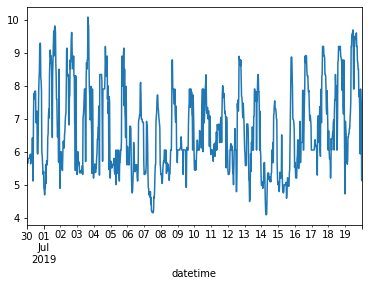

In [10]:
area = 'kansai'
df_test[area].plot()

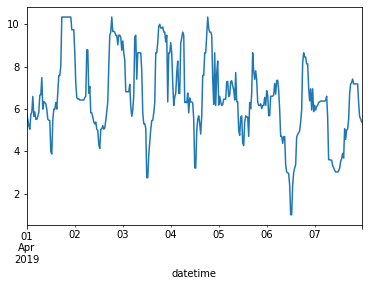

In [11]:
# 1 week of data
df_train[:48*7].kansai.plot()

## Let's use our causal model and see if it works

In [12]:
area_data = df_train.pivot(index='date', columns='slot', values=area)
area_data.head()

slot,1,2,3,4,5,6,7,8,9,10,...,39,40,41,42,43,44,45,46,47,48
date,,,,,,,,,,,,,,,,,,,,,
2019-04-01,5.75,5.48,5.20,5.04,5.73,5.85,6.59,5.65,5.85,5.51,...,10.34,10.34,10.34,10.34,10.34,10.34,10.34,9.74,9.74,9.74
2019-04-02,8.65,7.21,6.53,6.47,6.48,6.42,6.42,6.42,6.42,6.42,...,9.66,9.66,9.63,9.48,9.48,9.03,9.48,9.48,9.39,8.77
2019-04-03,9.21,8.65,8.31,6.81,6.81,6.81,6.81,7.16,6.13,5.65,...,9.82,9.82,9.87,9.63,9.63,9.16,9.48,6.33,8.65,8.65
2019-04-04,9.13,8.65,7.22,6.16,6.56,6.74,7.70,8.26,6.73,6.73,...,9.79,9.63,9.63,9.48,7.41,6.21,8.65,6.16,7.68,8.26
2019-04-05,6.18,6.59,6.33,6.16,6.21,6.46,6.46,6.46,7.28,7.30,...,7.37,6.33,6.16,6.16,6.24,6.01,6.16,6.16,6.54,6.16


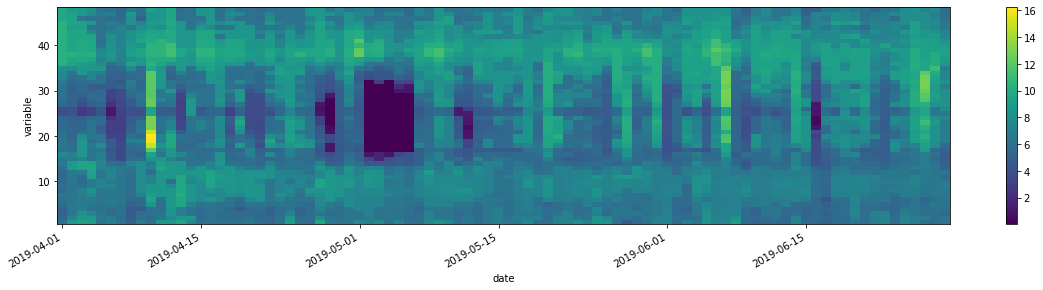

In [13]:
area_xarr = area_data.to_xarray().to_array()
plt.figure(figsize=(20,4))
area_xarr.plot()

What do you observe?

## Focusing on weekly patterns

In [14]:
by_weekday = df_train.groupby(['weekday', 'slot']).mean()
by_weekday.head()

sell_bids      buy_bids        traded    system  hokkaido  \
weekday slot                                                                 
0       1     1.434307e+07  1.504352e+07  1.231268e+07  7.191538  8.244615   
        2     1.520276e+07  1.554746e+07  1.276118e+07  6.687692  8.250769   
        3     1.586384e+07  1.562873e+07  1.289941e+07  6.478462  7.424615   
        4     1.615800e+07  1.574723e+07  1.301543e+07  6.418462  7.170000   
        5     1.626486e+07  1.585390e+07  1.304146e+07  6.500769  7.350000   

                tohoku     tokyo     chubu  hokuriku    kansai   chugoku  \
weekday slot                                                               
0       1     7.496923  7.496923  5.846923  5.846923  5.846923  5.846923   
        2     7.300000  7.300000  5.598462  5.598462  5.598462  5.598462   
        3     7.183846  7.183846  5.510000  5.510000  5.510000  5.510000   
        4     7.156923  7.156923  5.479231  5.479231  5.479231  5.479231   
        5     7.030000  7.030000  5.796154  5.796154  5.796154  5.796154   

               shikoku    kyushu  
weekday slot                      
0       1     5.846923  5.826154  
        2     5.598462  5.593077  
        3     5.510000  5.510000  
        4     5.479231  5.479231  
        5     5.796154  5.796154

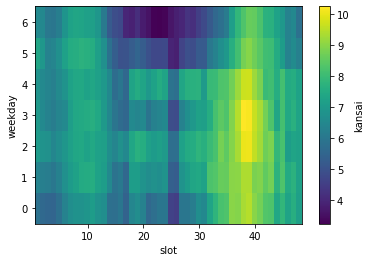

In [15]:
by_weekday.kansai.to_xarray().plot()

We are onto something

## Shall we make a model?

We don't have a clear linear relation between the input and the output.

In such a case a random forest model like xgboost can be very powerful.

In [16]:
from xgboost import XGBRegressor

## Warning: curse of dimensionality

Some model like xgboost easily fall into this trap.

You can easily add more and more inputs to the model, and will gradually get a near perfect fit on your training set.

As the number of parameters increase, the density of samples in your input space (hypercube!) becomes very low.

## Training the model

In [17]:
model = XGBRegressor()

In [18]:
# finally a function!
def make_X_y(df, area):
    X = df[['weekday', 'slot']].values
    y = df[area].values
    return X, y
X_train, y_train = make_X_y(df_train, area)
model.fit(X_train, y_train)

[18:51:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

## Lets's see the result on the training set

In [19]:
yhat_train = model.predict(X_train, area)

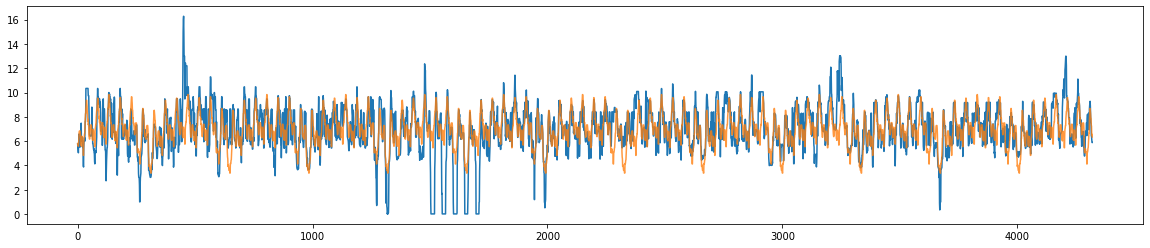

In [20]:
plt.figure(figsize=(20,4))
plt.plot(y_train)
plt.plot(yhat_train, alpha=0.8)

## What about errors

In [21]:
import numpy as np
def show_errors(y, yhat):
    error = yhat - y
    plt.hist(error)
    print(f'mean error {error.mean()}')
    print(f'mean absolute error {np.abs(error).mean()}')

mean error -0.00015892129474216353
mean absolute error 1.0261583922218394


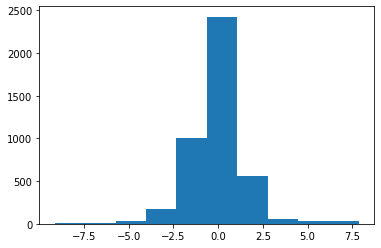

In [22]:
show_errors(y_train, yhat_train)

## Off to the test set

mean error 0.3406338323354721
mean absolute error 1.035334010283152


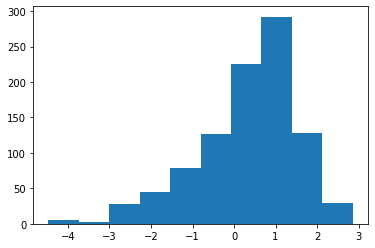

In [23]:
X_test, y_test = make_X_y(df_test, area)
yhat_test = model.predict(X_test)
show_errors(y_test, yhat_test)

Similar performance: no overfit, we can deploy!

## We are in business... or not

mean error -1.3399751130541167
mean absolute error 1.964571757098039


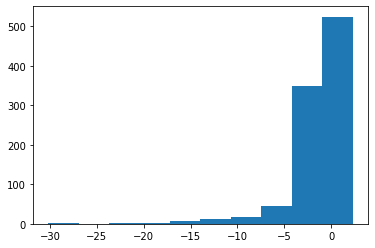

In [24]:
df_future = df[48*110:].copy()
X_future, y_future = make_X_y(df_future, area)
yhat_future = model.predict(X_future)
show_errors(y_future, yhat_future)

We've got some large errors here

## Time to back up

We rushed to make a model.

But did we really understand the problem. Does the error matter or not?

What is the expected revenue if we had a perfect prediction?

# Revenue model

In [25]:
np.abs(df_train.kansai - df_train.kansai.shift(1)).mean()

0.5292845566103257

Shall we predict this difference instead?

## Computing the result with the prediction

In [26]:
df_train['yhat'] = yhat_train
df_train['buy'] = (df_train.yhat.shift(-1) > df_train.yhat)
df_train['sell'] = df_train['buy'].shift(1).fillna(False)
((df_train.sell*1 - df_train.buy*1) * df_train[area]).mean()


0.15560185185185194

## What is the best storage duration?

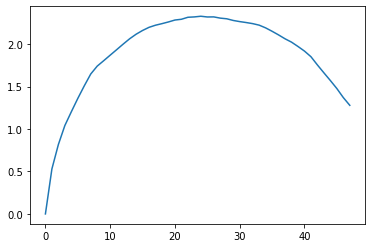

In [27]:
plt.plot([np.abs(df_train.shift(-a)[area] - df_train[area]).mean() for a in range(48)])

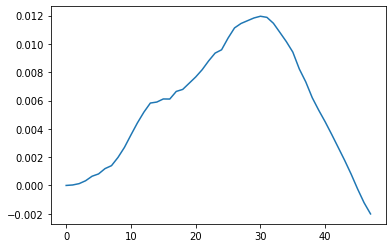

In [28]:
means = [(df_train.shift(-a)[area] - df_train[area]).mean() for a in range(48)]
plt.plot(means)

In [29]:
np.argmax(means)

30

# Overview of libraries used:

Pandas: data I/O and manipulation

xarray: 3+D pandas

matplotlib: plotting library

xgboost: machine learning

# Conclusion

* On Kaggle, what counts might be the prediction accuracy
* In real life, what counts is the payoff, and surviving
* always try to reframe and question the original problem
* find the right error metrics
* ultimately, you cannot predict the future from the past
* visualize!
* be skeptical


Thanks